In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2 as cv
# from scipy.ndimage.filters import sobel
from scipy.ndimage import sobel
import pathlib
from dotenv import load_dotenv

from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive
from tqdm.notebook import tqdm

In [3]:
import numpy_indexed as npi

In [4]:
from template_match import read_image_rgb, read_image_gray, template_match, detect_points, find_tolerance_limit, simplify_points, agglomerative_clustering, meanshift_clustering, invert_convolution_map, point_to_bbox
from process_template import template_tresholding

In [5]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))

In [6]:

from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [7]:
BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

## Mask-based Template matching

In [191]:
PLOT_NUMBER = 17
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [192]:
template_gray = read_image_gray(TEMPLATE_PATH)
image_gray = read_image_gray(PLOT_PATH)

template_rgb = read_image_rgb(TEMPLATE_PATH)
source_image = read_image_rgb(PLOT_PATH)
image_rgb = read_image_rgb(PLOT_PATH)  # here we will add mask


w, h = template_gray.shape[1], template_gray.shape[0]

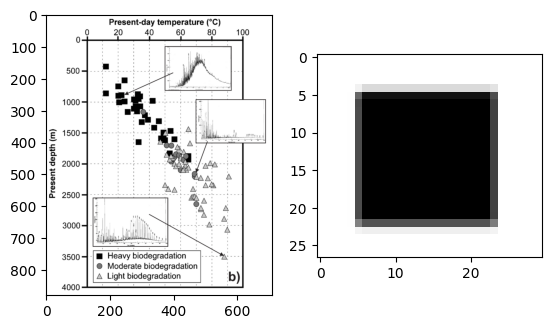

In [193]:
plt.subplot(1, 2, 1)
draw_image(source_image)

plt.subplot(1, 2, 2)
draw_image(template_rgb)

In [10]:
mask = template_tresholding(template_gray)
image_tresholded = template_tresholding(image_gray)

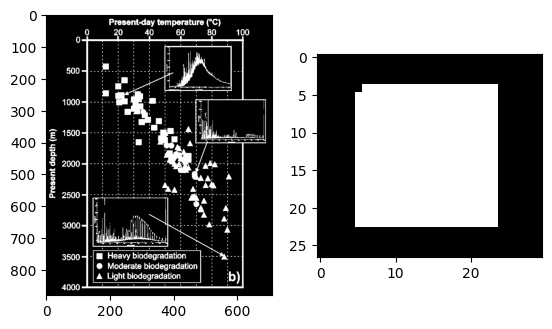

In [11]:
plt.subplot(1, 2, 1)
draw_image(image_tresholded)

plt.subplot(1, 2, 2)
draw_image(mask)

In [10]:
indexes_background = np.where(image_tresholded == 0)

image_rgb[indexes_background] = 0

(-0.5, 1147.5, 852.5, -0.5)

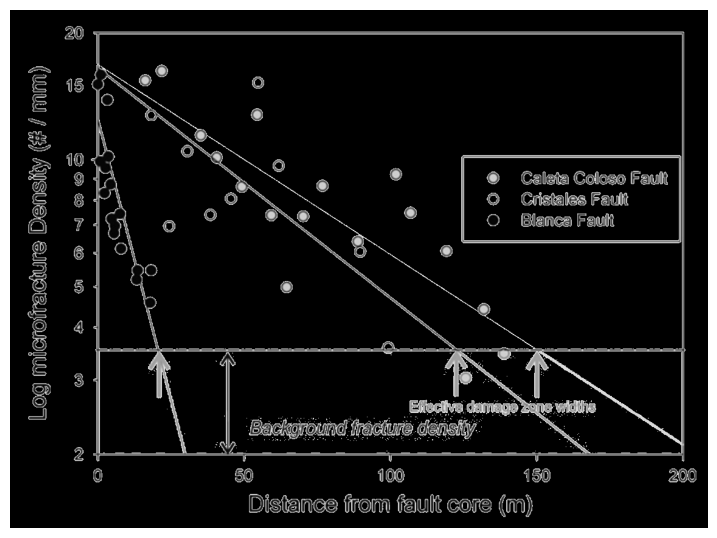

In [11]:
plt.figure(figsize=(9, 9))
draw_image(image_rgb)
# imshow_interactive(image_rgb)
plt.axis("off")

In [64]:
method = 'cv.TM_CCORR_NORMED'
# method = 'cv.TM_SQDIFF_NORMED'
# method = 'cv.TM_SQDIFF'

convolution_map, max_val = template_match(image_rgb, template_rgb, mask, method_name=method)

In [65]:
convolution_map

array([[            nan,            -inf,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
        -7.26011085e-10, -6.60945354e-10, -9.13958798e-10],
       [-4.53982230e-09,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [-1.23187394e-09, -1.25694721e-09, -1.58206315e-09, ...,
         6.78488932e-11, -2.80351020e-10, -2.48568777e-10],
       [ 3.93760413e-10,  3.59974245e-10,  1.13466035e-10, ...,
         2.20544458e-10,  1.06707310e-10, -2.11116714e-11],
       [-4.73260098e-10, -6.61180832e-10, -8.00823963e-10, ...,
        -1.17646104e-09, -1.13396714e-09, -1.24306554e-09]], dtype=float32)

In [62]:
np.where(np.isnan(convolution_map))

(array([  0,   0,   0, ..., 870, 870, 870]),
 array([   0,    2,    3, ..., 1717, 1718, 1719]))

In [66]:
nan_indexes = np.where( np.isnan(convolution_map) )
inf_indexes = np.where( np.isinf(convolution_map) )
convolution_map[nan_indexes] = 0
convolution_map[inf_indexes] = 0

if method == 'cv.TM_SQDIFF':
    convolution_map = convolution_map / np.max(convolution_map)

In [2]:
imshow_interactive(convolution_map)

In [225]:
tolerance_limit = find_tolerance_limit(convolution_map)
tolerance_limit

0.268

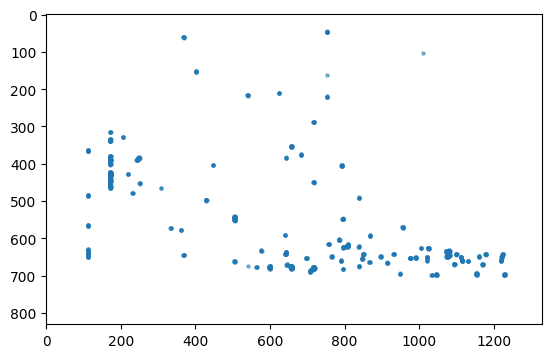

In [226]:
# run detection with limit tolerance value
max_val = np.max(convolution_map)
points = detect_points(convolution_map, max_val, tolerance=tolerance_limit)
draw_points_on_canvas(points, image_rgb)

In [227]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, image_rgb)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.268, min=0.001, step=0.001), Flo…

In [26]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, image_rgb)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.31, min=0.001, step=0.001), Floa…

In [109]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, image_rgb)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.101, min=0.001, step=0.001), Flo…

In [69]:
@interact(tolerance=widgets.FloatSlider(value=100, min=100, max=100000, step=100),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(image_gray)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, image_gray)

interactive(children=(FloatSlider(value=100.0, description='tolerance', max=100000.0, min=100.0, step=100.0), …

## Convolution implementation

In [96]:
def get_image_part(y: int, x: int, image: np.ndarray, w: int, h: int):
    return image[y : y+h, x : x+w]


def sqdiff(image_part: np.ndarray, template: np.ndarray):
    sqdiff_sum = np.sum((image_part.astype(np.float64) - template.astype(np.float64))**2)
    return sqdiff_sum

def sqdiff_with_mask(image_part: np.ndarray, template: np.ndarray, mask: np.ndarray):
    sqdiff = (image_part.astype(np.float64) - template.astype(np.float64))**2
    mask_indexes = np.where(mask == 0)
    sqdiff[mask_indexes] = 0
    sqdiff_sum = np.sum(sqdiff)

    return sqdiff_sum



def compute_mask_pixel_ratio(image_part: np.ndarray, mask: np.ndarray, mask_value: float):
    image_mask = image_part[:, :, 0]
    image_mask_indexes = np.where(image_mask == mask_value)
    template_non_mask_indexes = np.where(mask != 0)

    x, y = image_mask_indexes
    image_part_mask_pixel_coords = np.stack((x, y)).T

    x1, y1 = template_non_mask_indexes
    template_non_mask_pixel_coords = np.stack((x1, y1)).T

    true_mask_pixel_coords = npi.intersection(
        image_part_mask_pixel_coords,
        template_non_mask_pixel_coords
    )

    mask_pixel_ratio = len(true_mask_pixel_coords) / len(template_non_mask_pixel_coords)
    
    return mask_pixel_ratio



def sqdiff_v3(image_part: np.ndarray, template: np.ndarray, mask: np.ndarray):
    """
    OpenCV SQDIFF_NORMED implementation
    """
    image_part = image_part.astype(np.float64)
    template = template.astype(np.float64)
    mask = mask.astype(np.float64)

    sqdiff = np.sum( ((template - image_part) * mask)**2 )
    norm1 = np.sum( (template * mask)**2 )
    norm2 = np.sum( (image_part * mask)**2 )

    sqdiff_normed = sqdiff / np.sqrt(norm1 * norm2)

    return sqdiff_normed


def sqdiff_v4_custom(image_part: np.ndarray, template: np.ndarray, mask: np.ndarray):
    """
    SQDIFF_NORMED modification implementation
    """
    image_part = image_part.astype(np.float64)
    template = template.astype(np.float64)
    mask = mask.astype(np.float64)

    diff = (template - image_part)
    mask_indexes = np.where(mask == 0)

    diff[mask_indexes] = 0
    template[mask_indexes] = 0
    image_part[mask_indexes] = 0

    sqdiff = np.sum(diff**2)

    zero_image = False
    zero_template = False

    if np.all(template == 0):
        zero_template = True
        norm1 = 1
        norm2 = np.sum(image_part**2)
    else:
        norm1 = np.sum(template**2)
        norm2 = np.sum(image_part**2)
        
    if np.all(image_part == 0):
        zero_image = True
        norm1 = np.sum(template**2)
        norm2 = 1
    else:
        norm1 = np.sum(template**2)
        norm2 = np.sum(image_part**2)

    sqdiff_normed = sqdiff / np.sqrt(norm1 * norm2)

    
    if zero_image:
        print("image is zero")
        print(sqdiff, sqdiff_normed)
    if zero_template:
        print("template is zero")
        print(sqdiff, sqdiff_normed)

    # print(diff)
    print(sqdiff)
    print(norm1, norm2)
    print(sqdiff_normed)
    return diff




# def sqdiff_with_mask_v2(image_part: np.ndarray, template: np.ndarray, mask: np.ndarray):
#     sqdiff = ((image_part.astype(np.float64) - template.astype(np.float64)) * mask.astype(np.float64))**2
#     sqdiff_sum = np.sum(sqdiff)

#     return sqdiff_sum


def cv_sqdiff_normed(iamge_part: np.ndarray, template: np.ndarray, mask: np.ndarray):

    sqdiff = cv.matchTemplate(iamge_part, template, cv.TM_SQDIFF_NORMED, mask=mask)
    return sqdiff

In [98]:
PLOT_NUMBER = 11
MARKER_NUMBER = 4

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot9_marker{MARKER_NUMBER}.png"

# TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [99]:
source_image = read_image_rgb(PLOT_PATH)
template_rgb = read_image_rgb(TEMPLATE_PATH)

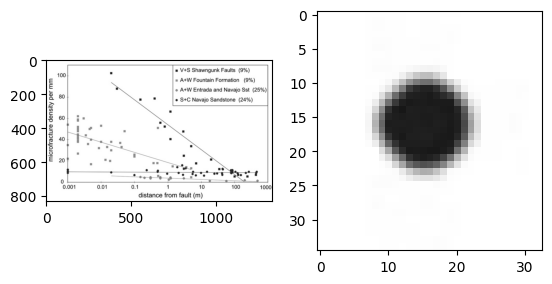

In [100]:
plt.subplot(1, 2, 1)
draw_image(source_image)

plt.subplot(1, 2, 2)
draw_image(template_rgb)

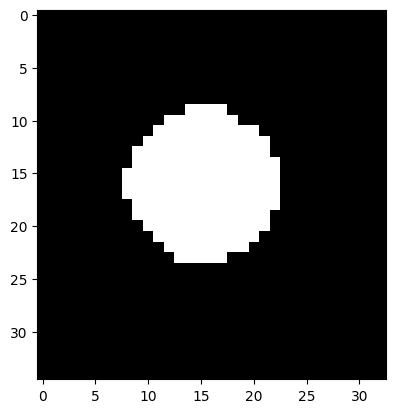

In [101]:
THRESHOLD_VALUE = 210
mask = template_tresholding(template_rgb, treshold=THRESHOLD_VALUE)

draw_image(mask)

**Replace black pixels**

In [102]:
image = np.copy(source_image)
template = np.copy(template_rgb)

In [103]:
zero_indexes_image = np.where((image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0))
zero_indexes_template = np.where((template[:, :, 0] == 0) & (template[:, :, 1] == 0) & (template[:, :, 2] == 0))
y_img, x_img = zero_indexes_image
y_tpl, x_tpl = zero_indexes_template

print("Number of black pixels on source image: ", len(zero_indexes_image[0]))
print("Number of black pixels on template: ", len(zero_indexes_template[0]))

Number of black pixels on source image:  269
Number of black pixels on template:  0


In [104]:
image[y_img, x_img, :] = 10
template[y_tpl, x_tpl, :] = 10

**Image tresholding**

In [105]:
# MASK_VALUE = -0.0001
MASK_VALUE = 0

In [106]:
image_mask = template_tresholding(image, treshold=THRESHOLD_VALUE)
indexes_background = np.where(image_mask == 0)
image_with_mask = np.copy(image)
# image_with_mask = image_with_mask.astype(np.float64)  # important step
image_with_mask[indexes_background] = MASK_VALUE

In [107]:
imshow_interactive(image_with_mask)

In [108]:
h_image, w_image = source_image.shape[0], source_image.shape[1]
h_template, w_template = template.shape[0], template.shape[1]

h_image, w_image

(831, 1330)

In [109]:
mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3))

mask_rgb[:, :, 0] = mask
mask_rgb[:, :, 1] = mask
mask_rgb[:, :, 2] = mask

In [110]:
# method_name = "CUSTOM_SQDIFF"

corr_map_height = h_image - h_template + 1
corr_map_width = w_image - w_template + 1
corr_map0 = np.zeros((corr_map_height, corr_map_width), dtype=np.float64)


for y in tqdm(range(corr_map_height)):
    for x in range(corr_map_width):
        image_part = get_image_part(y, x, image, w_template, h_template)

        # mask_pixel_ratio = compute_mask_pixel_ratio(image_part, mask)
        # if mask_pixel_ratio > 0.7:
        #     corr_map[y, x] = np.nan
        # else:
        #     corr_value = sqdiff_v3(image_part, template, mask_rgb)
        #     corr_map[y, x] = corr_value

        corr_value = sqdiff_v3(image_part, template, mask_rgb)
        # corr_value = sqdiff_v4_custom(image_part, template, mask_rgb)
        # corr_value = sqdiff_with_mask(image_part, template, mask_rgb)
        # corr_value = cv_sqdiff_normed(image_part, template, mask)
        corr_map0[y, x] = corr_value
        

  0%|          | 0/797 [00:00<?, ?it/s]

In [90]:
corr_map0 = invert_convolution_map(corr_map0)

In [92]:
# image = np.copy(source_image)
# image_mask = template_tresholding(image, treshold=tresh)
# indexes_background = np.where(image_mask == 0)
# image = image.astype(np.float64)  # important step
# image[indexes_background] = MASK_VALUE

corr_map = np.copy(corr_map0)

for y in tqdm(range(corr_map_height)):
    for x in range(corr_map_width):
        image_part = get_image_part(y, x, image_with_mask, w_template, h_template)

        mask_pixel_ratio = compute_mask_pixel_ratio(image_part, mask, mask_value=0)
        if mask_pixel_ratio > 0.4:
            corr_map[y, x] = np.nan

  0%|          | 0/871 [00:00<?, ?it/s]

In [65]:
# nan_indexes = np.where( np.isnan(corr_map) )
# corr_map2 = np.copy(corr_map)
# corr_map2[nan_indexes] = 0

In [1]:
# imshow_interactive(corr_map, width=800, height=700)

In [2]:
# imshow_interactive(corr_map0, width=800, height=700)

In [209]:
# corr_map = corr_map / np.nanmax(corr_map)
corr_map = invert_convolution_map(corr_map)

In [75]:
nan_indexes = np.where( np.isnan(corr_map0) )
# corr_map[nan_indexes] = 0
corr_map[nan_indexes] = np.nanmean(corr_map0)

In [95]:
corr_map0[np.where(corr_map0 > 1800)] = 0

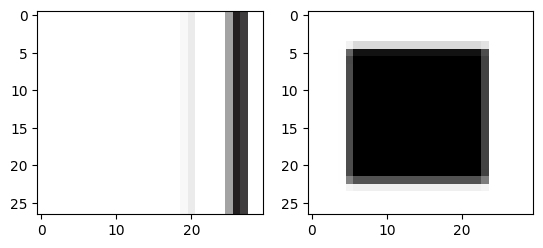

In [187]:
plt.subplot(1, 2, 1)
draw_image(source_image[y_min:y_max+1, x_min:x_max+1])

plt.subplot(1, 2, 2)
draw_image(template_rgb)

In [190]:
diff = sqdiff_v4_custom(source_image[y_min:y_max+1, x_min:x_max+1], template_rgb, mask_rgb)

60269604.0
989088.0 65996316.0
7.459694205626638


In [160]:
np.all(diff[:, :, 0] == diff[:, :, 2])

True

In [ ]:
image_part = get_image_part(0, 0, image, w_template, h_template)

In [ ]:
image_mask = image_part[:, :, 0]

image_mask_indexes = np.where(image_mask == MASK_VALUE)
template_non_mask_indexes = np.where(mask != 0)
template_non_mask_indexes

(array([ 5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13]),
 array([11, 10, 11, 12, 10, 11, 12,  9, 10, 11, 12, 13,  9, 10, 11, 12, 13,
         8,  9, 10, 11, 12, 13, 14,  8,  9, 10, 11, 12, 13, 14, 15,  7,  8,
         9, 10, 11, 12, 13, 14, 15,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

In [206]:
image_mask = image_part[:, :, 0]

image_mask_indexes = np.where(image_mask == 444444444444)
template_non_mask_indexes = np.where(mask != 0)
template_non_mask_indexes

x, y = image_mask_indexes
image_part_mask_pixel_coords = np.stack((x, y)).T

x, y = template_non_mask_indexes
template_non_mask_pixel_coords = np.stack((x, y)).T

true_mask_pixel_coords = npi.intersection(
    image_part_mask_pixel_coords,
    template_non_mask_pixel_coords
)

mask_pixel_ratio = len(true_mask_pixel_coords) / len(template_non_mask_pixel_coords)

if mask_pixel_ratio > 0.95:
    pass

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [171]:
mask_pixel_ratio

1.0

In [184]:
image_mask_indexes = np.where(image_part == 55555555555)
template_mask_indexes = np.where(mask == 0)
print(image_mask_indexes)
# print(template_mask_indexes)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [36]:
np.unique(tmp, return_counts=True)
# tmp += 0.0001

(array([  0.    , 122.0001]), array([1377,    3]))

In [34]:
np.count_nonzero(tmp) / tmp.size

0.002173913043478261

In [33]:
20 * 23 * 3

1380

In [21]:
corr_map = corr_map / np.max(corr_map)
corr_map = invert_convolution_map(corr_map)

NameError: name 'corr_map' is not defined

In [53]:
# corr_map_values = np.ravel(corr_map)
# hist, bin_edges = np.histogram(corr_map_values, bins=10)

# last_edge_start = bin_edges[-2]

In [68]:
# indexes_background_corr_map = np.where(corr_map > last_edge_start)

# corr_map2 = np.copy(corr_map)
# corr_map2[indexes_background_corr_map] = 20

In [383]:
# fig.write_image(
#     DATA_PATH / "results" / "correlation_maps_png" / f"corr_map_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.png",
#     scale=2
# )

# fig.write_html(
#     DATA_PATH / "results" / "correlation_maps_html" / f"corr_map_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.html",
# )

In [77]:
tolerance_limit = find_tolerance_limit(corr_map)
tolerance_limit

0.13

(997, 2)

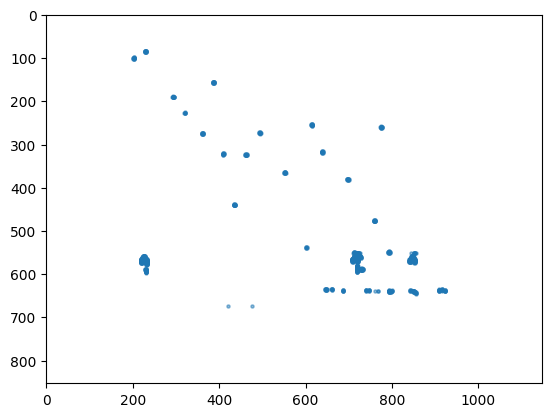

In [78]:
# run detection with limit tolerance value
max_val = np.max(corr_map)
points = detect_points(corr_map, max_val, tolerance=tolerance_limit)
draw_points_on_canvas(points, source_image)
points.shape

In [79]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(corr_map, max_val, tolerance=tolerance)

    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 10))
    draw_image(source_image)
    x += w_template // 2 - 1
    y += h_template // 2 - 1
    plt.scatter(x, y, s=50, c="yellow", 
            marker="*", 
            edgecolors='black',
            linewidths=0.3)
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.13, min=0.001, step=0.001), Floa…

**Save best result**

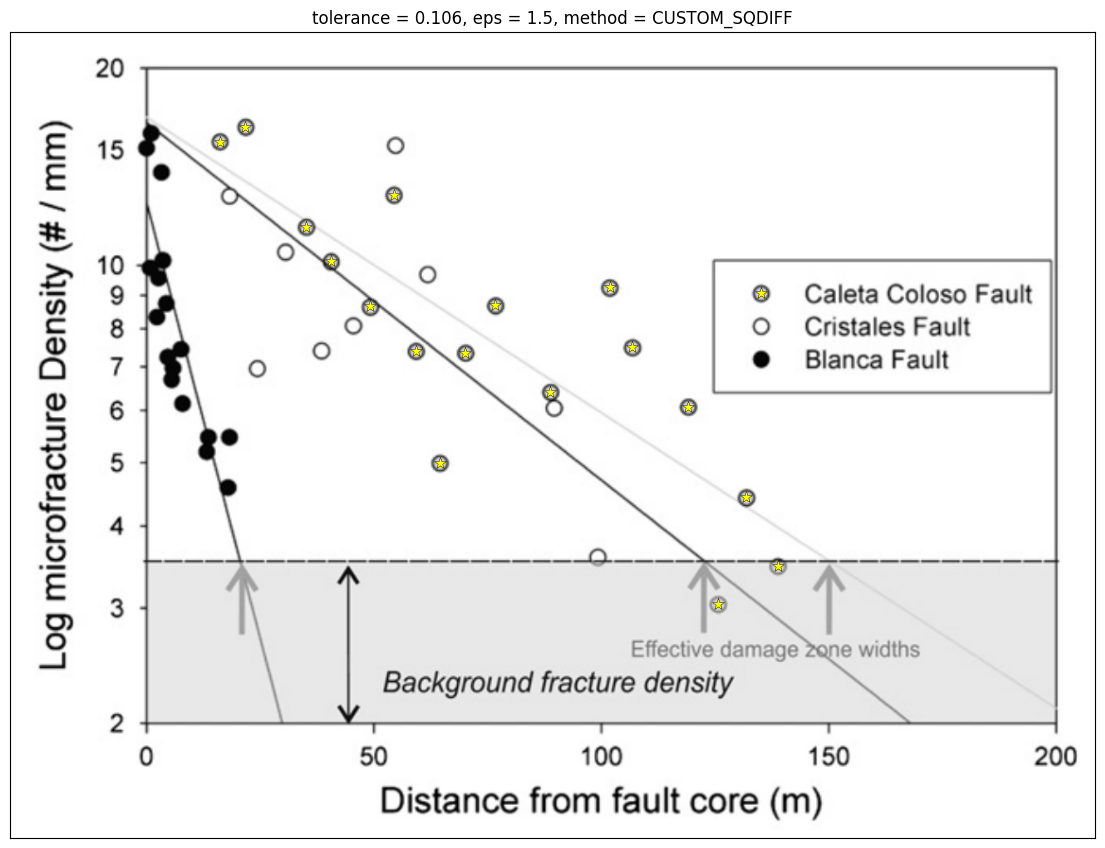

In [29]:
tolerance = 0.106
eps = 1.5

points = detect_points(corr_map, max_val, tolerance=tolerance)

cluster_labels = meanshift_clustering(points, eps)
# cluster_labels = agglomerative_clustering(points, eps)
actual_points = simplify_points(points, cluster_labels)
x = actual_points[:, 0]
y = actual_points[:, 1]

## founded points on original image
fig2 = plt.figure(figsize=(14, 14))
draw_image(source_image)
x += w_template // 2 - 1
y += h_template // 2 - 1
plt.scatter(x, y, s=80, c="yellow", 
            marker="*", 
            edgecolors='black',
            linewidths=0.3)
plt.xticks([]); plt.yticks([]);
plt.title(f"tolerance = {tolerance}, eps = {eps}, method = {method_name}")
plt.show()

# ## founded points on clear canvas
# plt.figure(figsize=(10, 6))
# draw_points_on_canvas(actual_points, source_image)

In [372]:
# fig2.savefig(
#     DATA_PATH / "results" / "detected_points_png" / f"detection_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.png",
# )

# np.savetxt(
#     DATA_PATH / "results" / "coordinates_detected_csv" / f"coords_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_{method_name}.csv",
#     actual_points,
#     delimiter=","
# )

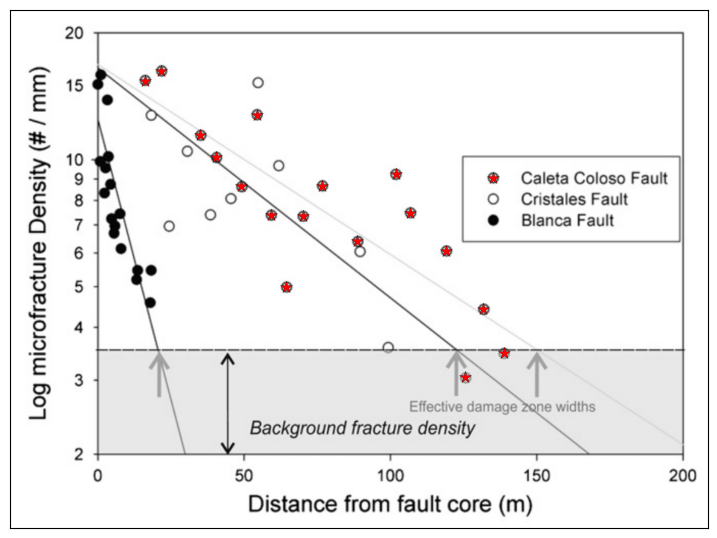

In [33]:
tolerance = 0.106
eps = 1.5

points = detect_points(corr_map, max_val, tolerance=tolerance)

cluster_labels = meanshift_clustering(points, eps)
# cluster_labels = agglomerative_clustering(points, eps)
actual_points = simplify_points(points, cluster_labels)
x = actual_points[:, 0]
y = actual_points[:, 1]

## founded points on original image
fig2 = plt.figure(figsize=(9, 9))
draw_image(source_image)
x += w_template // 2 - 1
y += h_template // 2 - 1
plt.scatter(x, y, s=80, c="red", 
            marker="*", 
            edgecolors='black',
            linewidths=0.2)
plt.xticks([]); plt.yticks([]);
# plt.title(f"tolerance = {tolerance}, eps = {eps}, method = {method_name}")
plt.show()

# ## founded points on clear canvas
# plt.figure(figsize=(10, 6))
# draw_points_on_canvas(actual_points, source_image)

#### Convert point on convolution map to bbox on source image

In [ ]:
index = np.where( convolution_map == 1.1025982)

# check
convolution_map[index]

array([], dtype=float32)

In [107]:
# point_on_map = (index[0][0], index[1][0])
point_on_map = (312, 218)

# print(index)
print(point_on_map)

(312, 218)


In [113]:
bbox = point_to_bbox(*point_on_map, w_template, h_template, corr_map)
x_min, x_max, y_min, y_max = bbox

In [114]:
assert source_image[y_min:y_max+1, x_min:x_max+1].shape == template.shape

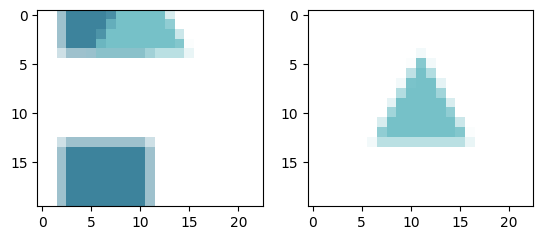

In [115]:
plt.subplot(1, 2, 1)
draw_image(source_image[y_min:y_max+1, x_min:x_max+1])


plt.subplot(1, 2, 2)
draw_image(template)

## Experiments

In [ ]:
# template_path = "/mnt/c/Users/admin/Desktop/plot_digitization/_code/data/custom_diff_tests/plot6_marker1.png"
# image_path = "/mnt/c/Users/admin/Desktop/plot_digitization/_code/data/plot10.png"


# part1_path = "/mnt/c/Users/admin/Desktop/plot_digitization/_code/data/custom_diff_tests/part1.png"
# part2_path = "/mnt/c/Users/admin/Desktop/plot_digitization/_code/data/custom_diff_tests/part2.png"

In [ ]:
## Grayscale
template = read_image_gray(template_path)
part = read_image_gray(part1_path)

template_float = np.zeros_like(template, dtype=np.float64)
template_float[:, :] = template[:, :]

part_float = np.zeros_like(part, dtype=np.float64)
part_float[:, :] = part[:, :]

## RGB
template = read_image_rgb(template_path)
part = read_image_rgb(image_path)

template_float = np.zeros_like(template, dtype=np.float64)
template_float[:, :, :] = template[:, :, :]

part_float = np.zeros_like(part, dtype=np.float64)
part_float[:, :, :] = part[:, :, :]


## MAsk
mask = template_tresholding(template)
image_thesholded = template_tresholding(part)

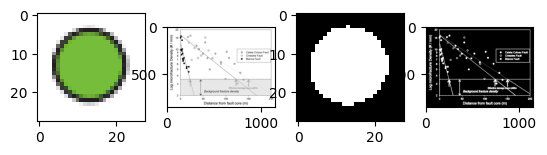

In [ ]:
plt.subplot(1, 4, 1)
draw_image(template)

plt.subplot(1, 4, 2)
draw_image(part)

plt.subplot(1, 4, 3)
draw_image(mask)

plt.subplot(1, 4, 4)
draw_image(image_thesholded)

In [ ]:
diff = diff_custom_gray(template_float, part_float, mask)

In [ ]:
# np.unique(diff, return_counts=True)

In [ ]:
indexes = np.where( diff < 600 )
y, x = indexes
# indexes

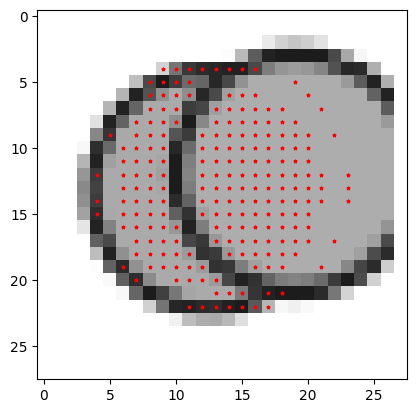

In [ ]:
draw_image(part)
plt.scatter(x, y, s=5, c="red", marker="*")

In [34]:
convolution_map = cv.matchTemplate(image, template, cv.TM_SQDIFF)

In [35]:
convolution_map

array([[5094812., 5094812., 5094820., ..., 5094812., 5094812., 5094812.],
       [5094804., 5094804., 5094796., ..., 5094812., 5094812., 5094812.],
       [5094804., 5094796., 5094796., ..., 5094812., 5094812., 5094812.],
       ...,
       [5094804., 5094804., 5094804., ..., 5094812., 5094812., 5094812.],
       [5094812., 5094812., 5094812., ..., 5094812., 5094820., 5094812.],
       [5094804., 5094804., 5094804., ..., 5094812., 5094812., 5094804.]],
      dtype=float32)

In [208]:
image.shape, template.shape

((898, 1755), (28, 28))

In [191]:
convolution_map

array([[5094812., 5094812., 5094820., ..., 5094812., 5094812., 5094812.],
       [5094804., 5094804., 5094796., ..., 5094812., 5094812., 5094812.],
       [5094804., 5094796., 5094796., ..., 5094812., 5094812., 5094812.],
       ...,
       [5094804., 5094804., 5094804., ..., 5094812., 5094812., 5094812.],
       [5094812., 5094812., 5094812., ..., 5094812., 5094820., 5094812.],
       [5094804., 5094804., 5094804., ..., 5094812., 5094812., 5094804.]],
      dtype=float32)

In [203]:
corr_array

array([[5094805., 5094805., 5094805., ..., 5094805., 5094805., 5094805.],
       [5094805., 5094805., 5094805., ..., 5094805., 5094805., 5094805.],
       [5094805., 5094805., 5094805., ..., 5094805., 5094805., 5094805.],
       ...,
       [5094805., 5094805., 5094805., ..., 5094805., 5094805., 5094805.],
       [5094805., 5094805., 5094805., ..., 5094805., 5094805., 5094805.],
       [5094805., 5094805., 5094805., ..., 5094805., 5094805., 5094805.]])

In [5]:
a = np.zeros((10, 11))

n = 0
for i in range(10):
    for j in range(11):
        a[i, j] = n
        n += 1

a

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
       [ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.],
       [ 22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.],
       [ 33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.],
       [ 44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.],
       [ 55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.],
       [ 66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.],
       [ 77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.],
       [ 88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.]])

In [136]:
y = 0
x = 10

w = 2
h = 3

In [137]:
a[y : y+h, x : x+w]

array([[10.],
       [21.],
       [32.]])

In [56]:
a = np.array([[1, 2],
              [3, 4]])

b = np.array([[5, 6],
              [7, 8]])

In [63]:
np.sum(a * b)

70

In [61]:
np.ravel(b)

array([5, 6, 7, 8])

In [58]:
np.ravel(a)

array([1, 2, 3, 4])